In [17]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, BatchNormalization, Dropout
from keras import regularizers

In [18]:
IMAGE_SIZE = (128, 128)
NUM_CLASSES = 2 
DATA_DIR = r'C:\Users\geeth\Downloads\test_data\YOLO-Object-Detection\DL project\Data'
DEFECTIVE_DIR = os.path.join(DATA_DIR, 'Defective_cubes')
QUALITY_DIR = os.path.join(DATA_DIR, 'Quality_cubes')

In [19]:
def load_data(directory):
    images = []
    labels = []
    label = 0 if directory == QUALITY_DIR else 1  
    for filename in os.listdir(directory):
        if filename.lower().endswith('.jpg'):
            img_path = os.path.join(directory, filename)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMAGE_SIZE)
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            images.append(img_array)
            labels.append(label)
    return np.array(images), np.array(labels)

In [20]:
defective_images, defective_labels = load_data(DEFECTIVE_DIR)
quality_images, quality_labels = load_data(QUALITY_DIR)
cube_images = np.concatenate([defective_images, quality_images], axis=0)
cube_labels = np.concatenate([defective_labels, quality_labels], axis=0)

In [21]:
train_images, test_images, train_labels, test_labels = train_test_split(cube_images, cube_labels, test_size=0.2, random_state=42)

In [22]:
train_images_normalized = train_images / 255.0
test_images_normalized = test_images / 255.0   

In [7]:
input_img = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
encoded = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
encoded = MaxPooling2D((2, 2), padding='same')(encoded)
encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
encoded = MaxPooling2D((2, 2), padding='same')(encoded)



In [8]:
decoded = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(decoded)

In [9]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [10]:
autoencoder.fit(train_images_normalized, train_images_normalized, epochs=2, batch_size=32, validation_data=(test_images_normalized, test_images_normalized))


Epoch 1/2

112/112 [==============================] - 58s 484ms/step - loss: 0.6337 - val_loss: 0.6153
Epoch 2/2
112/112 [==============================] - 52s 468ms/step - loss: 0.6148 - val_loss: 0.6136


In [11]:
denoised_train_images = autoencoder.predict(train_images_normalized)
denoised_test_images = autoencoder.predict(test_images_normalized)

28/28 [==============================] - 3s 105ms/step


In [15]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,  
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [23]:
# Create CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NUM_CLASSES, activation='sigmoid')  
])

In [27]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [40]:
history=model.fit(train_images_normalized, train_labels,  
          batch_size=32,
          epochs=10,
          validation_data=(test_images_normalized, test_labels))

Epoch 1/10
112/112 [==============================] - 33s 288ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0345 - val_accuracy: 0.9855
Epoch 2/10
112/112 [==============================] - 32s 290ms/step - loss: 0.0050 - accuracy: 0.9989 - val_loss: 0.0494 - val_accuracy: 0.9810
Epoch 3/10
112/112 [==============================] - 34s 302ms/step - loss: 0.0041 - accuracy: 0.9992 - val_loss: 0.0464 - val_accuracy: 0.9832
Epoch 4/10
112/112 [==============================] - 34s 307ms/step - loss: 0.0216 - accuracy: 0.9925 - val_loss: 0.0665 - val_accuracy: 0.9810
Epoch 5/10
112/112 [==============================] - 32s 286ms/step - loss: 0.0085 - accuracy: 0.9978 - val_loss: 0.0256 - val_accuracy: 0.9922
Epoch 6/10
112/112 [==============================] - 34s 303ms/step - loss: 0.0016 - accuracy: 0.9992 - val_loss: 0.0361 - val_accuracy: 0.9866
Epoch 7/10
112/112 [==============================] - 33s 294ms/step - loss: 0.0075 - accuracy: 0.9978 - val_loss: 0.0296 - val_ac

In [41]:
import matplotlib.pyplot as plt

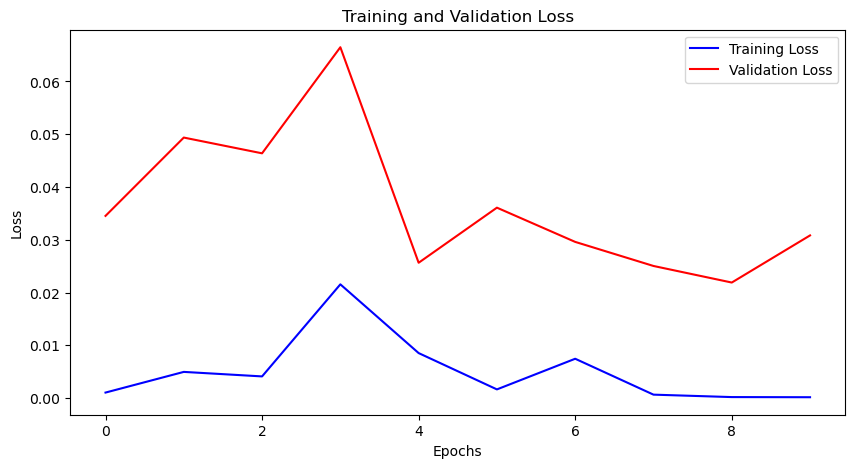

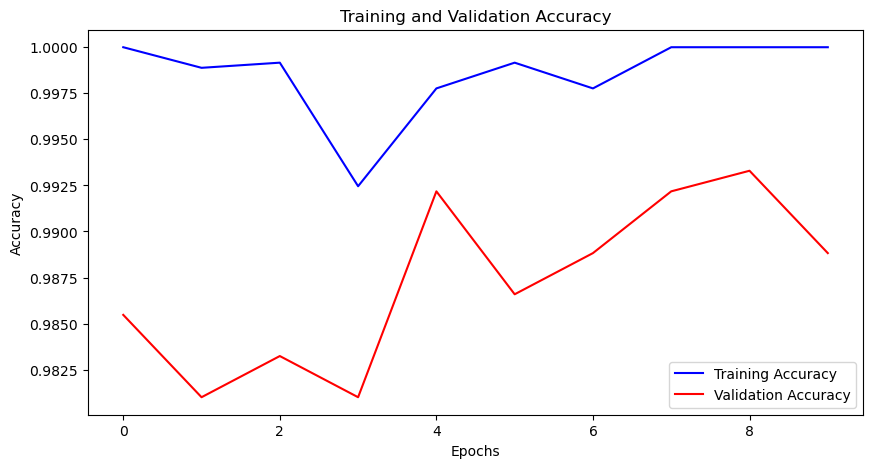

In [42]:
#plot the results
train_loss = history.history['loss']
val_loss = history.history['val_loss']

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy', color='blue')
plt.plot(val_acc, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [38]:
loss, accuracy = model.evaluate(test_images_normalized, test_labels)

28/28 [==============================] - 1s 50ms/step - loss: 0.0273 - accuracy: 0.9899


In [30]:
y_pred_prob = model.predict(test_images_normalized)

28/28 [==============================] - 2s 49ms/step


In [31]:
y_pred = np.argmax(y_pred_prob, axis=1)

In [32]:
accuracy = np.mean(y_pred == test_labels)

In [33]:
accuracy

0.9899441340782122

In [34]:
precision = precision_score(test_labels, y_pred)

In [35]:
recall = recall_score(test_labels, y_pred)

In [36]:
f1 = f1_score(test_labels, y_pred)


In [37]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9899441340782122
Precision: 0.9953810623556582
Recall: 0.9840182648401826
F1 Score: 0.9896670493685419


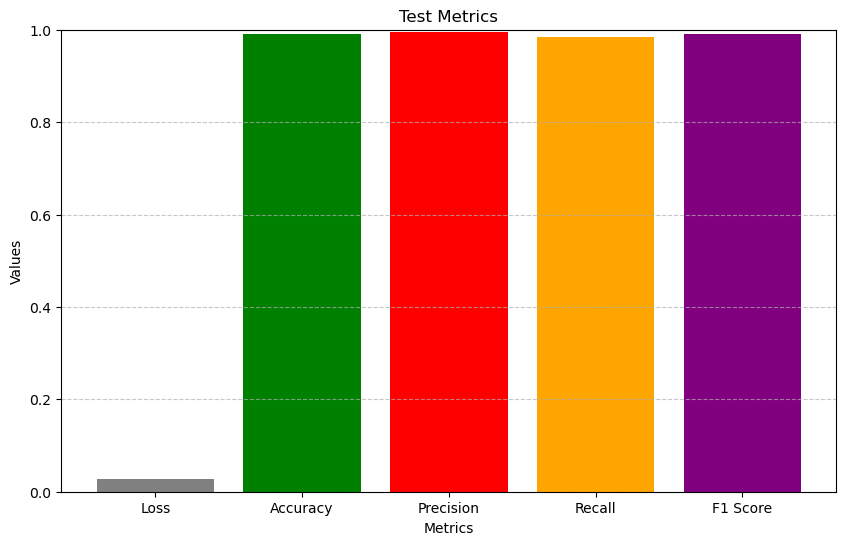

In [39]:



metrics_names = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1 Score']
metrics_values = [loss, accuracy, precision, recall, f1]

# Plot metrics
plt.figure(figsize=(10, 6))
plt.bar(metrics_names, metrics_values, color=['Gray', 'green', 'red', 'orange', 'purple'])
plt.title('Test Metrics')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [43]:
predicted_classes = (y_pred_prob > 0.5).astype("int32")

In [44]:
# Print the original labels and predicted labels side by side for comparison
for i in range(len(test_labels)):
    original_label = "Defective" if test_labels[i] == 1 else "Quality"
    predicted_label = "Defective" if predicted_classes[i][1] == 1 else "Quality"
    print(f"Original Label: {original_label[:20]}, Predicted Label: {predicted_label[:20]}")

Original Label: Quality, Predicted Label: Quality
Original Label: Quality, Predicted Label: Quality
Original Label: Defective, Predicted Label: Defective
Original Label: Defective, Predicted Label: Defective
Original Label: Quality, Predicted Label: Quality
Original Label: Defective, Predicted Label: Defective
Original Label: Defective, Predicted Label: Defective
Original Label: Quality, Predicted Label: Quality
Original Label: Quality, Predicted Label: Defective
Original Label: Defective, Predicted Label: Defective
Original Label: Defective, Predicted Label: Defective
Original Label: Defective, Predicted Label: Defective
Original Label: Defective, Predicted Label: Defective
Original Label: Defective, Predicted Label: Defective
Original Label: Defective, Predicted Label: Defective
Original Label: Defective, Predicted Label: Defective
Original Label: Quality, Predicted Label: Quality
Original Label: Quality, Predicted Label: Quality
Original Label: Defective, Predicted Label: Defective


In [49]:
import seaborn as sns
import pandas as pd

In [46]:
test_labels_str = ["Defective" if label == 1 else "Quality" for label in test_labels]
predicted_labels_str = ["Defective" if label == 1 else "Quality" for label in predicted_classes[:, 1]]

In [50]:
data = {"Original Label": test_labels_str, "Predicted Label": predicted_labels_str}
df = pd.DataFrame(data)

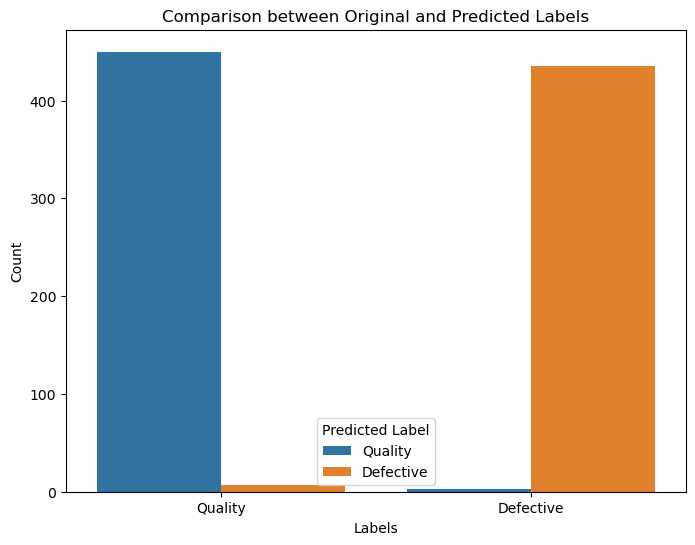

In [51]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x="Original Label", hue="Predicted Label")
plt.title("Comparison between Original and Predicted Labels")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.show()

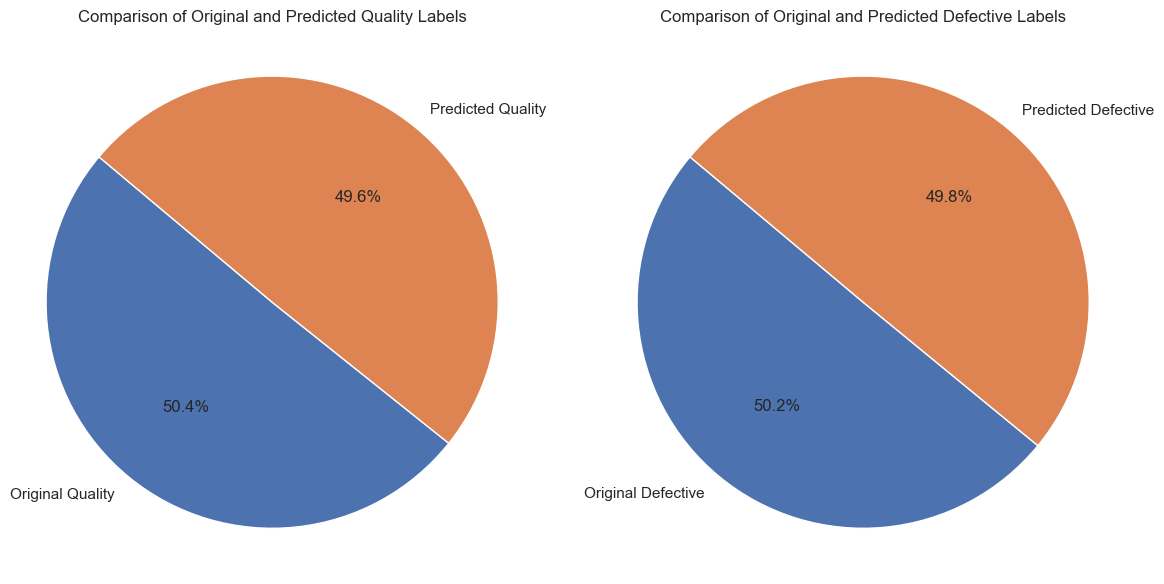

In [63]:
import matplotlib.pyplot as plt


quality_quality_count = sum((test_labels == 0) & (predicted_classes[:, 1] == 0))
defective_defective_count = sum((test_labels == 1) & (predicted_classes[:, 1] == 1))

quality_labels = ['Original Quality', 'Predicted Quality']
quality_sizes = [sum(test_labels == 0), quality_quality_count]


defective_labels = ['Original Defective', 'Predicted Defective']
defective_sizes = [sum(test_labels == 1), defective_defective_count]


fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot for quality 
axs[0].pie(quality_sizes, labels=quality_labels, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Comparison of Original and Predicted Quality Labels')
axs[0].axis('equal')  

# Plot for defective 
axs[1].pie(defective_sizes, labels=defective_labels, autopct='%1.1f%%', startangle=140)
axs[1].set_title('Comparison of Original and Predicted Defective Labels')
axs[1].axis('equal')  

plt.tight_layout()
plt.show()
